In [1]:
import json

import matplotlib.pyplot as plt
import numpy
import parmed
from paprika.analysis import fe_calc
from paprika.evaluator import Analyze
from paprika.io import load_restraints
from paprika.restraints.utils import extract_guest_restraints

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [4]:
boot_cycles = 2000
guest_resname = "BAM"
topology = "restrained.pdb"
trajectory = "production.dcd"
work_folder = "acd-bam/simulations"

## Load Restraints

In [2]:
attach_p_restraints = load_restraints(f"{work_folder}/attach-p/apr_restraints.json")
pull_p_restraints = load_restraints(f"{work_folder}/pull-p/apr_restraints.json")
attach_s_restraints = load_restraints(f"{work_folder}/attach-s/apr_restraints.json")
pull_s_restraints = load_restraints(f"{work_folder}/pull-s/apr_restraints.json")
release_restraints = load_restraints(f"{work_folder}/release/apr_restraints.json")

In [3]:
structure = parmed.load_file(f"{work_folder}/attach-p/a000/{topology}", structure=True)
guest_restraints = extract_guest_restraints(
    structure, pull_restraints, guest_resname, return_type="list"
)

## Estimate Free Energy for each phase

In [5]:
attach_p_results = Analyze.compute_phase_free_energy(
    "attach",
    attach_p_restraints,
    f"{work_folder}/attach-p",
    topology,
    trajectory,
    bootstrap_cycles=boot_cycles,
)

In [ ]:
attach_s_results = Analyze.compute_phase_free_energy(
    "attach",
    attach_s_restraints,
    f"{work_folder}/attach-s",
    topology,
    trajectory,
    bootstrap_cycles=boot_cycles,
)

In [6]:
pull_p_results = Analyze.compute_phase_free_energy(
    "pull",
    pull_p_restraints,
    f"{work_folder}/pull-p",
    topology,
    trajectory,
    bootstrap_cycles=boot_cycles,
)

In [ ]:
pull_s_results = Analyze.compute_phase_free_energy(
    "pull",
    pull_s_restraints,
    f"{work_folder}/pull-s",
    topology,
    trajectory,
    bootstrap_cycles=boot_cycles,
)

In [7]:
release_results = Analyze.compute_phase_free_energy(
    "release",
    release_restraints,
    f"{work_folder}/release",
    topology,
    trajectory,
    bootstrap_cycles=boot_cycles,
)

In [8]:
ref_state_work = Analyze.compute_ref_state_work(
    298.15, [restraint for restraint in guest_restraints if restraint is not None]
)

In [9]:
results_p = {**attach_p_results, **pull_p_results, **release_results}
results_s = {**attach_s_results, **pull_p_results, **release_results}

## Plot free energy profile

In [10]:
# fmt:off
lambda_attach = [0.0, 0.004, 0.008, 0.016, 0.024, 0.04, 0.055, 0.0865, 0.118, 0.181, 0.244, 0.37, 0.496, 0.748, 1.0]
lambda_release = [1.0, 0.748, 0.496, 0.37, 0.244, 0.181, 0.118, 0.0865, 0.055, 0.04, 0.024, 0.016, 0.008, 0.004, 0.0]
# fmt:on
pull_distance = np.linspace(6, 24, 46)

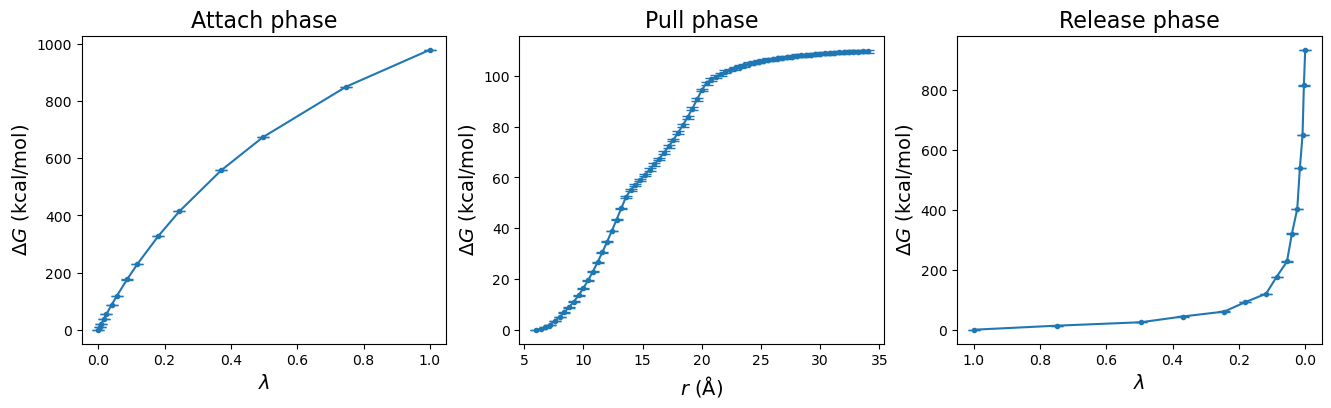

In [17]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.errorbar(
    lambda_attach,
    results_p["attach"]["ti-block"]["fe_matrix"][0, :],
    yerr=results_p["attach"]["ti-block"]["sem_matrix"][0, :],
    fmt=".-",
    capsize=4,
)
plt.xlabel(r"$\lambda$", fontsize=14)
plt.ylabel(r"$\Delta G$ (kcal/mol)", fontsize=14)
plt.title("Attach phase", fontsize=16)

plt.subplot(1, 3, 2)
plt.errorbar(
    pull_distance,
    results_p["pull"]["ti-block"]["fe_matrix"][0, :],
    yerr=results_p["pull"]["ti-block"]["sem_matrix"][0, :],
    fmt=".-",
    capsize=4,
)
plt.xlabel(r"$r$ ($\mathrm{\AA}$)", fontsize=14)
plt.ylabel(r"$\Delta G$ (kcal/mol)", fontsize=14)
plt.title("Pull phase", fontsize=16)

ax1 = plt.subplot(1, 3, 3)
ax1.errorbar(
    lambda_release,
    results_p["release"]["ti-block"]["fe_matrix"][0, :],
    yerr=results_p["release"]["ti-block"]["sem_matrix"][0, :],
    fmt=".-",
    capsize=4,
)
ax1.set_xlabel(r"$\lambda$", fontsize=14)
ax1.set_ylabel(r"$\Delta G$ (kcal/mol)", fontsize=14)
ax1.set_title("Release phase", fontsize=16)
ax1.invert_xaxis()

In [ ]:
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.errorbar(
    lambda_attach,
    results_s["attach"]["ti-block"]["fe_matrix"][0, :],
    yerr=results_s["attach"]["ti-block"]["sem_matrix"][0, :],
    fmt=".-",
    capsize=4,
)
plt.xlabel(r"$\lambda$", fontsize=14)
plt.ylabel(r"$\Delta G$ (kcal/mol)", fontsize=14)
plt.title("Attach phase", fontsize=16)

plt.subplot(1, 3, 2)
plt.errorbar(
    pull_distance,
    results_s["pull"]["ti-block"]["fe_matrix"][0, :],
    yerr=results_s["pull"]["ti-block"]["sem_matrix"][0, :],
    fmt=".-",
    capsize=4,
)
plt.xlabel(r"$r$ ($\mathrm{\AA}$)", fontsize=14)
plt.ylabel(r"$\Delta G$ (kcal/mol)", fontsize=14)
plt.title("Pull phase", fontsize=16)

ax1 = plt.subplot(1, 3, 3)
ax1.errorbar(
    lambda_release,
    results_s["release"]["ti-block"]["fe_matrix"][0, :],
    yerr=results_s["release"]["ti-block"]["sem_matrix"][0, :],
    fmt=".-",
    capsize=4,
)
ax1.set_xlabel(r"$\lambda$", fontsize=14)
ax1.set_ylabel(r"$\Delta G$ (kcal/mol)", fontsize=14)
ax1.set_title("Release phase", fontsize=16)
ax1.invert_xaxis()

## Print FE values

In [12]:
def print_results(results, method="ti-block"):
    fe_a = -1 * results["attach"][method]["fe"].magnitude
    sem_a = results["attach"][method]["sem"].magnitude
    fe_p = -1 * results["pull"][method]["fe"].magnitude
    sem_p = results["pull"][method]["sem"].magnitude
    fe_r = results["release"][method]["fe"].magnitude
    sem_r = results["release"][method]["sem"].magnitude
    fe_ref = -1 * ref_state_work.magnitude

    binding = fe_a + fe_p + fe_r + fe_ref
    sem = np.sqrt(sem_a**2 + sem_p**2 + sem_r**2)

    print(f"Analysis - {method}")
    print("-" * 25)
    print(f"Attach free-energy  = {fe_a:6.2f} +/- {sem_a:0.2f} kcal/mol")
    print(f"Pull free-energy    = {fe_p:6.2f} +/- {sem_p:0.2f} kcal/mol")
    print(f"Release free-energy = {fe_r:6.2f} +/- {sem_r:0.2f} kcal/mol")
    print(f"Ref state-work      = {fe_ref:6.2f}")
    print(f"Binding free-energy = {binding:6.2f} +/- {sem:0.2f} kcal/mol\n")

Analysis - ti-block
-------------------------
Attach free-energy  = -980.04 +/- 0.28 kcal/mol
Pull free-energy    = -109.77 +/- 0.59 kcal/mol
Release free-energy = 931.95 +/- 0.76 kcal/mol
Ref state-work      =   6.73
Binding free-energy = -151.13 +/- 1.01 kcal/mol



In [ ]:
print_results(results_p)

In [ ]:
print_results(results_s)

To combine both $\Delta G$'s to get a single value use:

$$\Delta G_{b} = -RT\ln\,\left[\exp\left(-\frac{\Delta G_{p}}{RT}\right) + \exp\left(-\frac{\Delta G_{s}}{RT}\right)\right]$$